# Aidge demonstration

Aidge is a collaborative open source deep learning library optimized for export and processing on embedded devices. With Aidge, you can create or import a Computational Graph from common Frameworks, apply editing on its structure, train it and export its architecture on many embedded devices. Aidge provides optimized functions for inference as well as training and many custom functionalities for the target device.

This notebook put in perspective the tool chain to import a Deep Neural Network from ONNX model and support its Inference in Aidge. The tool chain demonstrated is : 

![pipeline(1)](./static/pipeline_1.png)
 
In order to demonstrate this toolchain, the MNIST digit recognition task is used.

![MNIST](./static/MnistExamples.png)

## Setting up the notebook

### Define mermaid visualizer function

Aidge save graph using the mermaid format, in order to visualize the graph live in the notebook, we will setup the following function: 


In [1]:
import base64
from IPython.display import Image, display
import matplotlib.pyplot as plt

def visualize_mmd(path_to_mmd):
  with open(path_to_mmd, "r") as file_mmd:
    graph_mmd = file_mmd.read()

  graphbytes = graph_mmd.encode("ascii")
  base64_bytes = base64.b64encode(graphbytes)
  base64_string = base64_bytes.decode("ascii")
  display(Image(url=f"https://mermaid.ink/img/{base64_string}"))


### Generate ONNX
This step can take a few minutes for learning a Multi Layer Perceptron model on MNIST. The learning is performed on CPU with the PyTorch framework.

In [2]:
!./MNIST_model/generate_model.sh


Script directory: /data1/is156025/cm264821/aidge_packages/aidge/examples/tutorials/Aidge_tutorial/MNIST_model
/data1/is156025/cm264821/aidge_packages/aidge/examples/tutorials/Aidge_tutorial/MNIST_model/MLP_MNIST.onnx /data1/is156025/cm264821/aidge_packages/aidge/examples/tutorials/Aidge_tutorial/MNIST_model/digit.npy /data1/is156025/cm264821/aidge_packages/aidge/examples/tutorials/Aidge_tutorial/MNIST_model/output_digit.npy exist.


## Import Aidge

In order to provide a colaborative environnement in the plateform, the structure of Aidge is built on a core library that interfaces with multiple modules binded to python libraries. 
- ``aidge_core`` is the core library and offers all the basic functionnalities to create and manipulate the internal graph representation
- ``aidge_backend_cpu`` is a C++ module providing a generic C++ implementations for each component of the graph
- ``aidge_onnx`` is a module allowing to import ONNX to the Aidge framework
- ``aidge_export_cpp`` is a module dedicated to the generation of optimized C++ code

This way, ``aidge_core`` is free of any dependencies and the user can install what he wants depending on his use case.

In [3]:
import aidge_core

print("Available backends :")
aidge_core.Tensor.get_available_backends()


Available backends :


set()

As you can see, no backends are availables for the class ``Tensor``.

We need to import the ``aidge_backend_cpu`` module which will register itself automatically to ``aidge_core``.

In [4]:
import aidge_backend_cpu

print("Available backends :")
aidge_core.Tensor.get_available_backends()


Available backends :


{'cpu'}

For this tutorial, we will need to import ``aidge_onnx`` in order to load ONNX files, numpy in order to load data and matplotlib to display images.

In [5]:

import aidge_onnx
import numpy as np
import matplotlib.pyplot as plt


## ONNX Import
Import an ONNX model into Aidge internal graph representation.

![pipeline(2)](./static/pipeline_2.png)

In [6]:
model = aidge_onnx.load_onnx("MNIST_model/MLP_MNIST.onnx")


- _Flatten_output_0 (Flatten | GenericOperator)
	- axis : 1
- _fc1_Gemm_output_0 (Gemm)
- _Relu_output_0 (Relu)
- _fc2_Gemm_output_0 (Gemm)
- _Relu_1_output_0 (Relu)
- output (Gemm)
Info: using getRawOutput() on a GenericOperator.
Warning, the 1-th Parent of the child node already existed.
Warning, you're replacing a Parent.
Warning, the 2-th Parent of the child node already existed.
Warning, you're replacing a Parent.
Warning, the 1-th Parent of the child node already existed.
Warning, you're replacing a Parent.
Warning, the 2-th Parent of the child node already existed.
Warning, you're replacing a Parent.
Warning, the 1-th Parent of the child node already existed.
Warning, you're replacing a Parent.
Warning, the 2-th Parent of the child node already existed.
Warning, you're replacing a Parent.


As you can see in the logs, aidge imported a Node as a ``GenericOperator``:

```
- /Flatten_output_0 (Flatten | GenericOperator)
```

This is a fallback mechanism which allow aidge to load ONNX graph without failing even when encountering a node which is not available.
The ``GenericOperator`` act as a stub retrieving node type and attributes from ONNX. This allow to provide an implementation in a user script or as we will see to remove/replace them using aidge recipes. 

You can visualize the graph using the ``save`` method and the mermaid visualizer we have setup.

In [7]:
model.save("myModel")
visualize_mmd("myModel.mmd")


## Graph transformation 

![pipeline(3)](./static/pipeline_3.png)

In order to support the graph for inference we need to support all operators.
The imported model contains ```Flatten``` before the ```Gemm```  operator. The ```aidge.FC``` operator already supports the flatten operation. 
Graph transformation is required to support the graph for inference, i.e. remove the ```Flatten``` operator. 

Aidge graph transformation toolchain is the following process :

**1. Describe the graph pattern**


In order to find specific patterns inside a graph, there is first a need to describe those patterns. Aidge introduces an innovative way to describe graph patterns, **Graph Regular Expression**, inspired by regular expression from the formal language theory.

In this example the GraphRegEx used would be simple:

```
"Flatten->FC;"
```


**2. Match the described pattern**

Once the graph pattern is described with a graph regular expression, we apply an innovative graph matching algorithm to find patterns corresponding to the description.

This alogrithm will return all the Flatten followed by a Fully Connected nodes.


**3. Apply graph transformations on the matched patterns**

Now that we have matched the desired patterns we can apply graph transformation on it.
In this example we remove the ```Flatten``` operator from the graph.


All of these steps are embedded inside ``recipes`` functions. These recipes are available in ``aidge_core``, some recipes are:
- *fuse_batchnorm*: Fuse BatchNorm inside Conv or FC operator;
- *fuse_mul_add*: Fuse MatMul and Add operator into a FC operator;
- *remove_flatten*: Remove Flatten if it is before an FC operator.

In [8]:
aidge_core.remove_flatten(model)


Save the supported model into a mermaid format. If you want to visualize the graph, you can use : https://mermaid.live. 

In [9]:
model.save("mySupportedModel")
visualize_mmd("mySupportedModel.mmd")



## Inference

We now have a graph fully supported by aidge, we are ready to do some inference !

![pipeline(4)](./static/pipeline_4.png)

### Create an input tensor & its node in the graph

In order to perform an inferencewe will load an image from the MNIST dataset using Numpy.

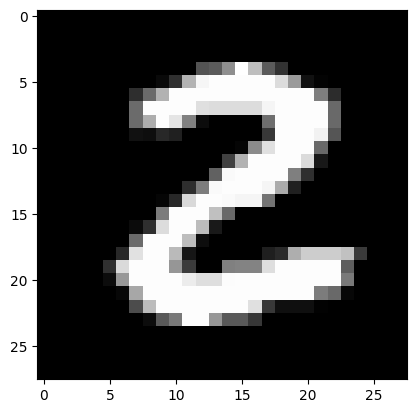

In [10]:
## Load input data & its output from the MNIST_model
digit = np.load("MNIST_model/digit.npy")
plt.imshow(digit[0][0], cmap='gray')


And in order to validate the result our model will provide, we will also load the output the PyTorch model povided for this image

In [11]:
output_model = np.load("MNIST_model/output_digit.npy")
print(output_model)


[[ -3.9212906    4.001701    18.503857    11.148807   -14.044725
   -0.09942764 -13.027787     3.221052     7.328435   -11.125868  ]]


Thanks to the Numpy interoperability we can create an Aidge ``Tensor`` using directly the numpy array storing the image.

In [12]:
input_tensor = aidge_core.Tensor(digit)
print(f"Aidge Input Tensor dimensions: \n{input_tensor.dims()}")


Aidge Input Tensor dimensions: 
[1, 1, 28, 28]


To add an input to the graph we create a ``Producer`` node and we set its output with the ``Tensor`` we have just created.

In [13]:
# Create Producer Node for the Graph
input_node = aidge_core.Producer(input_tensor, "X")

# Configuration for input (optional)
input_node.get_operator().set_datatype(aidge_core.DataType.Float32)
input_node.get_operator().set_backend("cpu")


We then link the producer node to the first node of the graph.

In [14]:
# Link Producer to the Graph
input_node.add_child(model)


### Configure the model for inference

At the moment the model has no implementation, it is only a datastructure. To set an implementation we will set a dataype and a backend.

In [15]:
# Configure the model
model.set_datatype(aidge_core.DataType.Float32)
model.set_backend("cpu")


### Create a scheduler and run inference

The graph is ready to run ! We just need to schedule the execution, to do this we will create a ``Scheduler`` object, which will take the graph and generate an optimized scheduling using a consummer producer heuristic.


In [16]:

# Create SCHEDULER
scheduler = aidge_core.SequentialScheduler(model)

# Run inference !
scheduler.forward(verbose=True)


run: _fc1_Gemm_output_0
run: _Relu_output_0
run: _fc2_Gemm_output_0
run: _Relu_1_output_0
run: output


In [17]:
# Assert results
for outNode in model.get_output_nodes():
    output_aidge = np.array(outNode.get_operator().output(0))
    print('Aidge prediction = ', np.argmax(output_aidge[0]))
    assert(np.allclose(output_aidge, output_model,rtol=1e-04))


Aidge prediction =  2


It is possible to save the scheduling in a mermaid format using:

In [18]:
scheduler.save_scheduling_diagram("schedulingSequential")
visualize_mmd("schedulingSequential.mmd")


## Export

Now that we have tested the imported graph we can look at one of the main feature of Aidge, the export of computationnal graph to an hardware target using code generation.

![pipeline(5)](./static/pipeline_5.png)

### Generate an export in C++
In this example we will generate a generic C++ export.
This export is not based on the `cpu` backend we have set before.

In this example we will create a standalone export which is abstracted from the Aidge platform.


In [19]:
! rm -r myexport


In [20]:
!ls myexport


ls: cannot access 'myexport': No such file or directory


Generating a ``cpu`` export recquires the ``aidge_export_cpp`` module.

Once the module is imported you just need one line to generate an export of the graph.

In [21]:
import aidge_export_cpp

# Export the model in C++ standalone
aidge_export_cpp.export("myexport", model, scheduler)


The export function will generate :
- **dnn/layers** layers configuration;
- **dnn/parameters** folder with parameters;
- **dnn/include/dnn.h** API to use the export;
- **dnn/include/network_functions.h** header file for kernels;
- **dnn/memory** memory management information;
- **dnn/src** kernel source code + forward function;
- **main.cpp** This file is an export of the scheduler, it allows
- **Makefile** To compile the main.cpp

In [22]:
!tree myexport


myexport
├── Makefile
├── dnn
│   ├── include
│   │   ├── dnn.hpp
│   │   ├── kernels
│   │   │   ├── activation.hpp
│   │   │   ├── fullyconnected.hpp
│   │   │   └── macs.hpp
│   │   └── network
│   │       ├── rescaling.hpp
│   │       ├── typedefs.hpp
│   │       └── utils.hpp
│   ├── layers
│   │   ├── _Relu_1_output_0.h
│   │   ├── _Relu_output_0.h
│   │   ├── _fc1_Gemm_output_0.h
│   │   ├── _fc2_Gemm_output_0.h
│   │   └── output.h
│   ├── memory
│   │   └── mem_info.h
│   ├── parameters
│   │   ├── fc1_bias.h
│   │   ├── fc1_weight.h
│   │   ├── fc2_bias.h
│   │   ├── fc2_weight.h
│   │   ├── fc3_bias.h
│   │   └── fc3_weight.h
│   └── src
│       └── forward.cpp
└── main.cpp

8 directories, 22 files


### Generate an input file for tests

To test the export we need to provide data, to do so we will export the numpy array using:

In [23]:
aidge_export_cpp.export_to_static("inputs", digit.reshape(-1), "myexport/inputs.h")


### Compile the export

In [25]:
!cd myexport && make


g++  -O2 -Wall -Wextra -MMD -I. -I./dnn -I./dnn/include -I./dnn/layers -I./dnn/parameters -c dnn/src/forward.cpp -o build/./dnn/src/forward.o 
In file included from dnn/src/forward.cpp:8:
./dnn/include/kernels/fullyconnected.hpp:27: warning: ignoring #pragma omp parallel [-Wunknown-pragmas]
   27 | #pragma omp parallel for
      | 
In file included from ./dnn/include/kernels/fullyconnected.hpp:8,
                 from dnn/src/forward.cpp:8:
./dnn/include/kernels/activation.hpp: In instantiation of ‘Output_T saturate(T, int32_t) [with Output_T = float; T = float; typename std::enable_if<std::is_floating_point<T>::value>::type* <anonymous> = 0; int32_t = int]’:
./dnn/include/kernels/activation.hpp:52:30:   required from ‘Output_T activation_forward_value(Sum_T, int, ActivationFunction_T, const Rescaling_T&) [with Output_T = float; Sum_T = float; Rescaling_T = NoScaling]’
./dnn/include/kernels/fullyconnected.hpp:45:58:   required from ‘void fullyconnected_forward(const Input_T*, Output_T*

### Run the export

In [26]:
!./myexport/bin/run_export


0: -3.92129
1: 4.0017
2: 18.5039
3: 11.1488
4: -14.0447
5: -0.099429
6: -13.0278
7: 3.22105
8: 7.32844
9: -11.1259
